In [1]:
import pandas as pd
import gzip
import json
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

In [2]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Beauty_5.json.gz')
df2 = getDF('meta_Beauty.json.gz')

In [3]:
text_mat = pd.read_csv('stemmed_text.csv')


In [4]:
df = df.drop(["reviewerName", "summary", "reviewTime"], axis=1, inplace=False)
df2 = df2.drop(["imUrl", "related", "brand"], axis=1, inplace = False)
new_df = df.merge(df2, how='inner', on='asin')
new_df['helpful_num'] = df['helpful'].apply(lambda x: x[0])
new_df['helpful_denom'] = df['helpful'].apply(lambda x: x[1])
new_df1 = new_df.drop("helpful", axis = 1)
new_df1.head()
count = new_df1.groupby("asin", as_index=False).count()

new_df2 = pd.merge(new_df1, count, how='right', on=['asin'])
new_df2.columns
new_df2["numberReview"] = new_df2["reviewerID_y"]
#Filter out products with review numbers >= 50
dfCount = new_df2[new_df2.numberReview >= 50]

In [5]:
df_temp = dfCount[['reviewerID_x','asin','overall_x','salesRank_x','categories_x','price_x']]
df_temp.columns = ['reviewerID','asin','overall','salesRank','categories','price']

In [6]:
df_temp = df_temp[pd.notnull(df_temp['salesRank'])]
price_avg = np.mean(df_temp['price'])
df_temp['price'] = df_temp['price'].fillna(price_avg)

In [7]:
df_temp = df_temp.merge(text_mat)
df_temp.drop(['Unnamed: 0'],axis = 1, inplace = True)


In [8]:
df_temp.head()

,reviewerID,asin,overall,salesRank,categories,price,love thi,thi product,highli recommend,receiv thi,...,time use,don use,use thi,thi stuff,thi item,use thi product,like use,long hair,don think,use time
0,AEEJGDRRGLBB1,B000050B6U,2.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3,4,2,0,...,1,0,5,0,1,0,0,4,0,0
1,A2K6LI89NAD2J2,B000050B6U,5.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3,4,2,0,...,1,0,5,0,1,0,0,4,0,0
2,A1P9UMP1XSE6MI,B000050B6U,5.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3,4,2,0,...,1,0,5,0,1,0,0,4,0,0
3,A4WX0FZ1MMAUH,B000050B6U,5.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3,4,2,0,...,1,0,5,0,1,0,0,4,0,0
4,AHP55PFHJL0H8,B000050B6U,2.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3,4,2,0,...,1,0,5,0,1,0,0,4,0,0


In [9]:
sc = []
for i in range(len(list(df_temp['salesRank']))):
    v_out = list(df_temp['salesRank'])[i]
    sc.append(list(v_out.values())[0])

In [10]:
df_temp['rank'] = sc
df_temp1 = df_temp.drop('salesRank', axis=1, inplace=False)
df_temp['categories'] = df_temp['categories'].apply(lambda x: x[0])
df_temp['category1'] = df_temp['categories'].apply(lambda x: x[3] if len(x) > 3 else x[0])
df_temp['category2'] = df_temp['categories'].apply(lambda x: x[len(x)-1])
df_temp.drop(['categories'],axis = 1,inplace =True)
labels_cat1, levels_cat1 = pd.factorize(df_temp['category1'])
labels_cat2, levels_cat2 = pd.factorize(df_temp['category2'])

df_temp['category1'] = labels_cat1
df_temp['category2'] = labels_cat2

df_temp.drop('salesRank',axis = 1,inplace = True)
df_temp.head()

,reviewerID,asin,overall,price,love thi,thi product,highli recommend,receiv thi,thi just,great price,...,thi stuff,thi item,use thi product,like use,long hair,don think,use time,rank,category1,category2
0,AEEJGDRRGLBB1,B000050B6U,2.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
1,A2K6LI89NAD2J2,B000050B6U,5.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
2,A1P9UMP1XSE6MI,B000050B6U,5.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
3,A4WX0FZ1MMAUH,B000050B6U,5.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
4,AHP55PFHJL0H8,B000050B6U,2.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0


In [477]:
df_temp.to_csv("feature_matrix.csv")

In [11]:
item_only = df_temp.copy()

item_only.index = item_only['asin']
#item_only.drop(['asin'],axis = 1, inplace = True)
#sim_item = cosine_similarity(item_only)
item_only.head()

,reviewerID,asin,overall,price,love thi,thi product,highli recommend,receiv thi,thi just,great price,...,thi stuff,thi item,use thi product,like use,long hair,don think,use time,rank,category1,category2
asin,,,,,,,,,,,,,,,,,,,,,
B000050B6U,AEEJGDRRGLBB1,B000050B6U,2.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
B000050B6U,A2K6LI89NAD2J2,B000050B6U,5.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
B000050B6U,A1P9UMP1XSE6MI,B000050B6U,5.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
B000050B6U,A4WX0FZ1MMAUH,B000050B6U,5.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0
B000050B6U,AHP55PFHJL0H8,B000050B6U,2.0,13.95,3,4,2,0,0,2,...,0,1,0,0,4,0,0,3225,0,0


In [12]:
item_only = item_only.groupby("asin", as_index= True).mean()
item_only.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'asin' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,overall,price,love thi,thi product,highli recommend,receiv thi,thi just,great price,product just,easi use,...,thi stuff,thi item,use thi product,like use,long hair,don think,use time,rank,category1,category2
asin,,,,,,,,,,,,,,,,,,,,,
B000050B6U,4.313725,13.95,3,4,2,0,0,2,0,3,...,0,1,0,0,4,0,0,3225,0,0
B000052WYD,3.680000,4.20,3,15,1,0,1,1,0,0,...,0,0,2,0,0,0,0,54508,1,1
B000052YM7,4.010753,9.67,4,41,5,1,1,1,0,0,...,10,1,13,0,0,1,2,561,2,2
B000052YMR,4.614035,18.99,4,14,3,0,0,0,0,0,...,6,0,4,1,0,0,1,6216,3,2
B0000530ED,4.009709,7.85,11,23,4,0,0,0,0,3,...,8,1,2,1,4,0,1,20927,4,3


In [13]:

sim_item = cosine_similarity(item_only)
item_pos = {}
all_items = df_temp.asin.unique()
for i in range(len(all_items)):
    curItemID = all_items[i]
    item_pos[curItemID] = i

In [14]:
def minimal_and_factorize(df_original):

    df_minimal = df_original[['reviewerID','asin','overall']]
    labels_user, levels_user = pd.factorize(df_minimal['reviewerID'])
    df_minimal['userID'] = labels_user
    df_minimal = df_minimal.drop('reviewerID',axis = 1)
    labels_item, levels_item = pd.factorize(df_minimal['asin'])
    df_minimal['itemID'] = labels_item
    df_minimal = df_minimal.drop('asin',axis = 1)
    df_minimal['rating'] = df_minimal['overall'].astype(int)
    df_minimal = df_minimal.drop('overall',axis = 1)
        
    return df_minimal,(labels_user,levels_user),(labels_item,levels_item)

In [15]:
def factorize(df_original):
    df_minimal = df_original
    labels_user, levels_user = pd.factorize(df_minimal['reviewerID'])
    df_minimal['userID'] = labels_user
    df_minimal = df_minimal.drop('reviewerID',axis = 1)
    labels_item, levels_item = pd.factorize(df_minimal['asin'])
    df_minimal['itemID'] = labels_item
    df_minimal = df_minimal.drop('asin',axis = 1)
    
    
    df_minimal['rating'] = df_minimal['overall'].astype(int)
    df_minimal = df_minimal.drop('overall',axis = 1)
    df_minimal['rank'] = df_minimal['rank'].astype(int)
    
    #some of them don't have the fourth category in the list, so the catogiries will take the first element 
    df_minimal['categories'] = df_minimal['categories'].apply(lambda x: x[0])
    df_minimal['categories'] = df_minimal['categories'].apply(lambda x: x[3] if len(x) > 3 else x[0])
    labels_cat, levels_cat = pd.factorize(df_minimal['categories'])
    df_minimal['categories'] = labels_cat
    
    
    #price go into a few bins
    bins = [0, 10, 20, 30, 40, 50, 250]
    labels = [1,2,3,4,5,6]
    df_minimal['binned_price'] = pd.cut(df_minimal['price'], bins=bins, labels=labels)
    
    return df_minimal,(labels_user,levels_user),(labels_item,levels_item),(labels_cat,levels_cat)

In [1038]:
train_orig,test_orig = train_test_split(df_temp1, test_size = 0.25, random_state = 7)
train,label_level_u_train,label_level_i_train = minimal_and_factorize(train_orig)
test,label_level_u_test,label_level_i_test = minimal_and_factorize(test_orig)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1039]:
#train_dict: {user:{item,rating}}
train_dict = {}
for user in train.userID.unique():
    sub_dict = {}
    subset = train[train['userID'] == user]
    for item in subset.itemID:
        sub_dict[item] = list(subset[subset['itemID']==item].rating)[0]
    train_dict[user] = sub_dict

#test_dict: {(user,item):rating}   
test_dict = {}
for i in range(test.shape[0]):
    user = test.iloc[i].userID
    item = test.iloc[i].itemID
    test_dict[user,item] = test.iloc[i].rating

In [18]:
def transform_train_dict(dictionary):
    """
    This function transbose the user-item matrix pass into it to a item-user matrix
    """
    transform = {}
    for user, itemList in dictionary.items():
        for item, rating in itemList.items():
            if item not in transform.keys():
                transform[item] = {user : rating}
            else:    
                transform[item].update({user : rating})
    return transform

In [1041]:
n_users = df_temp1.reviewerID.unique().shape[0]
n_items = df_temp1.asin.unique().shape[0]
print(n_users)
print(n_items)

17552
729


In [1042]:
#create user-item matrix for train and test set
train_matrix = train.pivot(index='userID', columns='itemID', values='rating')
train_matrix = np.array(train_matrix.fillna(0))

test_matrix = test.pivot(index='userID', columns='itemID', values='rating')
test_matrix = np.array(test_matrix.fillna(0))

In [1043]:
#compute cosine similarity between users and users
sim_user = cosine_similarity(train_matrix)

In [877]:
#compute cosine similarity between items
sim_item_new = cosine_similarity(train_matrix.T)

In [1044]:
#user_pos dict: {userID: position in sim_user matrix}
#associate userID with position in similarity matrix
user_pos = {}
all_users = train.userID.unique()
for i in range(len(all_users)):
    curUserID = all_users[i]
    user_pos[curUserID] = i
    


In [24]:
#Find K nearest neighbors for user i
def find_neighbors(train,sim_matrix,user_i,k = 5):
    user_pos = {}
    all_users = train.userID.unique()
    for i in range(len(all_users)):
        curUserID = all_users[i]
        user_pos[curUserID] = i
    
    all_users = train.userID.unique()
    sim_for_user_i = [(user,sim_matrix[user_pos[user],user_pos[user_i]])
                     for user in all_users if user != user_i]
    sim_for_user_i.sort(key = lambda x: x[1],reverse = True)
    #return ID of users most similar to user_i
    return [x[0] for x in sim_for_user_i][:k]

In [25]:
def find_neighbors_item(train,sim_matrix,item_i,k = 5):
    all_items = train.itemID.unique()
    sim_for_item_i = [(item,sim_matrix[item,item_i]) for item in all_items if item != item_i]
    sim_for_item_i.sort(key = lambda x: x[1],reverse = True)
    #return ID of items most similar to item_i
    return [x[0] for x in sim_for_item_i][:k]

In [26]:
#Calculate average rating in a dictionary 
def mean_rating(dictionary):
    total = sum([val for val in dictionary.values()])
    return (total.astype(float)) / len(dictionary)

In [27]:
#RMSE for dictionary
#Here prediction is a dictionary of the form {(user,item),rating}
def RMSE_dict(prediction,test_dict):
    error = 0
    for key in prediction.keys():
        error += (prediction[key]-test_dict[key])**2
    return np.sqrt(error/len(prediction.keys()))

In [28]:
#RMSE for matrix
#Here prediction is a user-item matrix for train
#test_matrix is user-item matrix for test
def rmse_matrix(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten() 
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, test_matrix))

In [1062]:
class item_based_CF():
    
    def __init__(self, sim_item):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.sim_item = sim_item
        
      
   
    def fit(self, train, train_dict, k=3):
        '''
        Fit item based CF model
        '''
        
        self.average = {}
        self.numer = {}
        self.denom = {}
        sim_item = self.sim_item
        
        train_dict_item = transform_train_dict(train_dict)
        for user in train_dict.keys():
            #train to get nearest neighbor
            itemset = train_dict[user] 

            for item in itemset.keys():
                #if item in test_item.keys():
                nn = find_neighbors_item(train, sim_item, item, k)
                self.average[item] = mean_rating(train_dict_item[item])
                mutual = list(set(nn) & set(list(train_dict[user].keys())))
                w_sim = [sim_item[item, i] for i in mutual]
                r_sim = [train_dict[user][i] for i in mutual]
                w_array = np.array(w_sim)
                r_array = np.array(r_sim)
                den = sum(abs(w_array))
                num = sum(w_array*r_array)
                self.numer[(user,item)] = num
                self.denom[(user,item)] = den
                
        self.fitted = True
                
        return self
    
    def predict_train(self, train_dict):
        prediction = {}
        for user in train_dict.keys():
            itemset = train_dict[user]
            for item in itemset.keys():
                numer = self.numer[(user,item)]
                denom = self.denom[(user,item)]
                
                if denom == 0:
                    prediction[(user,item)]= self.average[item]
                else:
                    prediction[(user,item)]= numer/denom
        return prediction
    
    def predict_test(self,train_dict,test_dict):
        prediction = {}
        
        numer = 0
        denom = 0
        
        for user_item in test_dict.keys():
            user,item = user_item
            
            if user in train_dict.keys():
                if item in train_dict[user].keys():
                    numer = self.numer[(user,item)]
                    denom = self.denom[(user,item)]
                    
            if denom == 0:
                prediction[(user,item)]= self.average[item]
            else:
                prediction[(user,item)]= numer/denom
        return prediction
    

In [30]:
def transform_train(train_dict):
        train_dict_trans = {}
        for users in train_dict.keys():
            for item, rating in train_dict[users].items():
                train_dict_trans[(users, item)] = rating
        return train_dict_trans

In [1063]:
item_based= item_based_CF(sim_item)
model = item_based.fit(train, train_dict)
y = model.predict_train(train_dict)

In [1064]:
train_dict_trans = transform_train(train_dict)

In [1065]:
RMSE_dict(y, train_dict_trans)

1.0490829978506646

In [1066]:
y_test = model.predict_test(train_dict, test_dict)
RMSE_dict(y_test, test_dict)

1.283425621686656

In [35]:
class user_based_CF():
    
    def __init__(self, sim_user):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.user_item = sim_user
        self.average = {}
        self.numer = {}
        self.denom = {}
      
   
    def fit(self, train, train_dict, k=3):
        '''
        Fit item based CF model
        '''
        
        
        
        train_dict_item = transform_train_dict(train_dict)
        counter = 0
        for user in train_dict.keys():
            counter += 1
            if counter%1000 ==0:
                print(counter)

            self.average[user] = mean_rating(train_dict[user])
            item_rating = train_dict[user]
            nn = find_neighbors(train,sim_user,user)

            for item in item_rating.keys():

                mutual = list(set(nn) & set(list(train_dict_item[item].keys())))
                num = sum([sim_user[user_pos[user],user_pos[cust]]*(train_dict_item[item][cust]-mean_rating(train_dict[cust]))
                            for cust in mutual])
                den = sum(np.abs([sim_user[user_pos[user],user_pos[cust]] for cust in mutual]))
                self.numer[(user,item)] = num
                self.denom[(user,item)] = den
                
                
        self.fitted = True
                
        return self
    
    def predict_train(self, train_dict):
        prediction = {}
        
        numer = 0
        denom = 0
        
        for user in train_dict.keys():
            itemset = train_dict[user]
            for item in itemset.keys():
                numer = self.numer[(user,item)]
                denom = self.denom[(user,item)]
                
                if denom == 0:
                    prediction[(user,item)]= self.average[user]
                else:
                    prediction[(user,item)]= numer/denom + self.average[user]
                
        return prediction
    
    def predict_test(self,train_dict,test_dict):
        prediction = {}
        
        numer = 0
        denom = 0
        
        for user_item in test_dict.keys():
            user,item = user_item
            
            if user in train_dict.keys():
                if item in train_dict[user].keys():
                    numer = self.numer[(user,item)]
                    denom = self.denom[(user,item)]
                    
            if denom == 0:
                prediction[(user,item)]= self.average[user]
            else:
                prediction[(user,item)]= numer/denom + self.average[user]
        return prediction




In [ ]:
user_based= user_based_CF(sim_user)
model_user = user_based.fit(train, train_dict,k = 10)
y_user = model_user.predict_train(train_dict)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [1067]:
RMSE_dict(y_user, train_dict_trans)

0.82404954007003306

In [1068]:
y_user_test = model_user.predict_test(train_dict, test_dict)
RMSE_dict(y_user_test, test_dict)

1.4793004501344382

In [843]:
class MF_SGD():

    def __init__(self, n_users, n_items, factors=150, maxIter=10000000, lr=0.01, conv=1e-20, lamda = 0.01):
        
        '''
        self.n_users = n_users
        self.n_items = n_items
        self.factors = factors
        self.maxIter = maxIter
        self.lr = lr
        self.conv = conv
        self.lamda = lamda
        self.latent_mat_user = np.random.rand(n_users, self.factors) / 3
        self.latent_mat_item = np.random.rand(n_items, self.factors) / 3
        

		#self.user2idx = {user: idx for (idx, user) in enumerate(self.users)}
		#self.item2idx = {item: idx for (idx, item) in enumerate(self.items)}
        '''
        
        self.n_users = n_users
        self.n_items = n_items
        self.factors = factors
        self.maxIter = maxIter
        self.lr = lr
        self.conv = conv
        self.lamda = lamda
        self.latent_mat_user = np.random.rand(self.n_users, self.factors) / 3
        self.latent_mat_item = np.random.rand(self.n_items, self.factors) / 3
        
    
    
    def fit(self,train):
        
        #self.idx2user = {idx: user for (idx, user) in enumerate(train['userID'])}
        #self.idx2item = {idx: item for (idx, item) in enumerate(train['itemID'])}
        self.user2idx = {idx: user for (idx, user) in enumerate(train['userID'])}
        self.item2idx = {idx: item for (idx, item) in enumerate(train['itemID'])}
       
        loss_list = []
        iteration = 0
        hist_loss = 0
        while iteration<self.maxIter:

            #if iteration%10000 == 0:
                #print(iteration)

            loss = 0
            index = np.random.randint(len(train))

            uid, iid, rate = train.iloc[index]
            error = rate - np.dot(self.latent_mat_user[uid], self.latent_mat_item[iid])
            loss += error**2 + self.lamda*(np.linalg.norm(self.latent_mat_user[uid])+np.linalg.norm(self.latent_mat_item[iid]))
            old_user = self.latent_mat_user[uid]
            old_item = self.latent_mat_item[iid]
            self.latent_mat_user[uid] += self.lr*(error*self.latent_mat_item[iid]-self.lamda*old_user)
            self.latent_mat_item[iid] += self.lr*(error*self.latent_mat_user[uid]-self.lamda*old_item)
            iteration+=1
            loss_list.append(loss)
            diff = hist_loss-loss
            #to converge
            if abs(hist_loss) > abs(loss):
                self.lr *= 1.05
            else:
                self.lr *= 0.5
            if abs(diff) < abs(self.conv):
                break
            hist_loss = loss
        return self
    
    def predict_one(self,uid,iid):
        userIdx = self.user2idx[uid]
        itemIdx = self.item2idx[iid]

        return np.dot(self.latent_mat_user[userIdx],self.latent_mat_item[itemIdx].T)
    
    def predict(self,test_mat):
        pred_mat = np.dot(self.latent_mat_user,self.latent_mat_item.T)
        #prediction={}
        
        prediction = [self.predict_one(row[1]['userID'], row[1]['itemID']) for row in test_dict.iterrows()]
        
        '''
        for i in range(len(pred_mat)):
            idxuser = self.idx2user[i]
            for j in range(pred_mat.shape[1]):
                idxitem = self.idx2item[j]
                prediction[(idxuser,idxitem)] = pred_mat[i,j]
        '''
        return prediction



        


In [844]:
mf_based= MF_SGD(n_users, n_items, factors=150, maxIter=10000000, lr=0.01, conv=1e-20, lamda = 0.01)
model_mf = mf_based.fit(train)


In [868]:
y_mf_train_mat = model_mf.predict(train)
y_mf_test_mat = model_mf.predict(test)
#y_mf_train = model_mf.predict(train_dict, train_dict)

In [859]:
np.sqrt(mean_squared_error(y_mf_train,train['rating']))

1.1512809336870706

In [869]:
#convert test prediction matrix into dictionary
y_mf = {}
for i in range(len(y_mf_test_mat)):
    user = test.iloc[i]['userID']
    item = test.iloc[i]['itemID']
    y_mf[(user,item)] = y_mf_test_mat[i]


In [948]:
#convert test prediction matrix into dictionary
y_mf_train = {}
for i in range(len(y_mf_train_mat)):
    user = train.iloc[i]['userID']
    item = train.iloc[i]['itemID']
    y_mf_train[(user,item)] = y_mf_train_mat[i]

In [949]:
def RMSE_mf(prediction, test_dict):
    error = 0
    count = 0
    for key in test_dict.keys():
        if key in prediction.keys():
            count +=1
            error += (prediction[key]-test_dict[key])**2
    return np.sqrt(error/count)

In [872]:
RMSE_mf(y_mf, test_dict)

1.1361618424985915

#### Correlation

In [950]:

y_mf_revised = {}
for key in y_user.keys():
    y_mf_revised[key] = y_mf_train[key]


In [887]:
y_mf_test = {}
for key in y_user_test.keys():
    y_mf_test[key] = y_mf[key]

In [951]:

df1 = pd.DataFrame.from_dict(y_mf_revised, orient='index')
df2 = pd.DataFrame.from_dict(y_user, orient='index')
df3 = pd.DataFrame.from_dict(y, orient='index')
df = pd.concat([df1, df2, df3], axis=1)
df.columns = ['mf', 'user_based', 'item_based']


In [952]:
df1.corrwith(df2, axis = 0)

0    0.004542
dtype: float64

In [953]:
df2.corrwith(df3, axis = 0)

0    0.282323
dtype: float64

In [954]:
df1.corrwith(df3, axis = 0)

0    0.013505
dtype: float64

In [955]:

train_test_dict = {}
mf_revised_dict = {}
user_revised_dict = {}
item_revised_dict = {}
for key in train_dict_trans.keys():
    if key in y_user.keys():
        train_test_dict[key] = train_dict_trans[key]
        mf_revised_dict[key] = y_mf_revised[key]
        user_revised_dict[key] = y_user[key]
        item_revised_dict[key] = y[key]


In [891]:
new_test_dict = {}
mf_test_dict = {}
user_test_dict = {}
item_test_dict = {}
for key in test_dict.keys():
    if key in y_mf_test.keys():
        new_test_dict[key] = test_dict[key]
        mf_test_dict[key] = y_mf_test[key]
        user_test_dict[key] = y_user_test[key]
        item_test_dict[key] = y_test[key]

In [956]:

df1 = pd.DataFrame.from_dict(mf_revised_dict, orient='index')
df2 = pd.DataFrame.from_dict(user_revised_dict, orient='index')
df3 = pd.DataFrame.from_dict(item_revised_dict, orient='index')
true_target = pd.DataFrame.from_dict(train_test_dict, orient='index')


In [892]:
df1_test = pd.DataFrame.from_dict(mf_test_dict, orient='index')
df2_test = pd.DataFrame.from_dict(user_test_dict, orient='index')
df3_test = pd.DataFrame.from_dict(item_test_dict, orient='index')
true_target_test = pd.DataFrame.from_dict(new_test_dict, orient='index')

In [957]:

df_feature = pd.concat([df1, df2, df3], axis = 1)
df_feature.columns = ['mf','user','item']


In [893]:
df_feature_test = pd.concat([df1_test, df2_test, df3_test], axis = 1)
df_feature_test.columns = ['mf','user','item']

In [958]:

df_full = pd.concat([df1, df2, df3,true_target], axis =1 )
df_full['user_item'] = df_full.index
df_full.columns = ['mf','user','item','true','user_item']


In [896]:
df_full_test = pd.concat([df1_test, df2_test, df3_test,true_target_test], axis =1 )
df_full_test['user_item'] = df_full_test.index
df_full_test.columns = ['mf','user','item','true','user_item']

df_full_test.head()

,mf,user,item,true,user_item
"(0, 0)",4.263096,3.000000,3.759563,5,"(0, 0)"
"(1, 1)",4.312568,4.479167,4.255319,4,"(1, 1)"
"(2, 2)",4.066407,5.396342,4.815534,2,"(2, 2)"
"(3, 3)",4.243171,4.941176,4.300000,5,"(3, 3)"
"(4, 4)",4.265776,4.000000,4.205128,4,"(4, 4)"


In [994]:
#find overlapping user_item pairs
overlap = []
train_key = set(df_full.user_item.unique())
test_key = set(df_full_test.user_item.unique())
for tk in train_key.intersection(test_key):
    overlap.append(tk)
len(overlap)



147

In [1015]:
uipair = list(overlap)

overlap = [[x[0],x[1]] for x in uipair]

In [1001]:
df_all = pd.concat([df_full,df_full_test],axis = 0)
df_all['user_item'] = df_all.index


In [1012]:
uipair = list(df_all['user_item'])

tolist = [[x[0],x[1]] for x in uipair]
df_all['user_item'] = tolist


In [972]:
counter = 0
train_key = set(df_full.user_item.unique())
test_key = set(df_full_test.user_item.unique())
for tk in train_key.intersection(test_key):
    counter += 1
counter


147

#### Ensemble - logistic regression

In [898]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import Bootstrap

In [899]:
df_full_test['user_item'] = df_full_test.index

In [1029]:
df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_all[['mf','user','item']], df_all['true'], test_size = 0.2)

#df_train_X = df_full[['mf','user','item']]
#df_train_y = df_full['true']
#df_test_X = df_full_test[['mf','user','item']]
#df_test_y = df_full_test['true']


In [979]:
model_lr = LogisticRegressionCV(cv=5)
model_lr.fit(df_train_X, df_train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [980]:
pred_lr = model_lr.predict(df_test_X)

In [981]:
np.sqrt(mean_squared_error(pred_lr, df_test_y))

1.244875244327138

In [982]:
RMSE_dt = []
for i in range(1,10):
    model_dt = DecisionTreeRegressor(max_depth=i)
    model_dt.fit(df_train_X, df_train_y)
    prediction=model_dt.predict(df_test_X)
    RMSE_dt.append(np.sqrt(mean_squared_error(prediction, df_test_y)))
RMSE_dt

[1.0048389677618963,
 0.96869084480211387,
 0.95368571043611716,
 0.94748511747350261,
 0.9394231414799592,
 0.93468502829074696,
 0.93627277722049496,
 0.94031094018571904,
 0.95391951513634954]

In [983]:
model_dt = DecisionTreeRegressor(max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3)
model_dt.fit(df_train_X, df_train_y)
prediction=model_dt.predict(df_test_X)

In [920]:
df_train_X.head()

,mf,user,item
"(2732, 104)",3.999884,1.6,4.260163
"(5872, 673)",4.527906,3.8,4.307692
"(478, 129)",4.223164,3.5,3.931818
"(970, 203)",4.076831,4.0,4.028571
"(636, 407)",4.931451,4.6,4.191781


In [984]:
model_dt.feature_importances_ 

array([ 0.        ,  0.86921437,  0.13078563])

In [910]:
#prediction by feature importance
pred_by_imp = df_test_X['item']*0.70955061 + df_test_X['user']*0 + df_test_X['mf']*0.29044939
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.143251493813719

In [923]:
pred_by_imp = df_test_X['mf']*0.24699709 + df_test_X['user']*0.31755736 + df_test_X['item']*0.43544554
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.1784866859993197

In [925]:
pred_by_imp = df_test_X['item']*0.45799689 + df_test_X['user']*0.32836491 + df_test_X['mf']*0.2136382
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.1838574003072546

In [926]:
pred_by_imp = df_test_X['item']*0.39206743 + df_test_X['user']*0.43179998 + df_test_X['mf']*0.17613259
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.217395169811418

In [927]:
pred_by_imp = df_test_X['item']*0.5948879 + df_test_X['user']*0.13425015 + df_test_X['mf']*0.27086195
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.1467731907356167

In [928]:
pred_by_imp = df_test_X['item']*0.2 + df_test_X['user']*0.1 + df_test_X['mf']*0.7
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.1292095971685134

In [985]:
pred_by_imp = df_test_X['item']*0.15 + df_test_X['user']*0.05 + df_test_X['mf']*0.8
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.0998715223023576

In [986]:
pred_by_imp = df_test_X['item']*0.25 + df_test_X['user']*0.05 + df_test_X['mf']*0.7
np.sqrt(mean_squared_error(pred_by_imp,df_test_y))

1.0870169625263582

Gradient Boosting

In [351]:
from sklearn.metrics import mean_absolute_error
import sklearn.ensemble

In [1030]:
n_est = 100

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [3,4,5,6,7,8,9 ],
    "learning_rate": [ 0.03,0.05,0.1,0.2,0.25 ],
    "min_samples_split" : [ 2,3,4 ]
}

gbr = sklearn.ensemble.GradientBoostingRegressor(criterion='mse')
clf = sklearn.model_selection.GridSearchCV(gbr, cv=5, param_grid=tuned_parameters,
        scoring='neg_mean_absolute_error')
clf.fit(df_train_X, df_train_y) 
best = clf.best_estimator_

In [1031]:
best

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [1032]:
gb = sklearn.ensemble.GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
gb.fit(df_train_X,df_train_y)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [1037]:
gb = sklearn.ensemble.GradientBoostingRegressor()
gb.fit(df_train_X,df_train_y)
gb_default_pred = gb.predict(df_test_X)
np.sqrt(mean_squared_error(df_test_y,gb_default_pred))

0.93110538973769441

RMSE:  0.93069121102


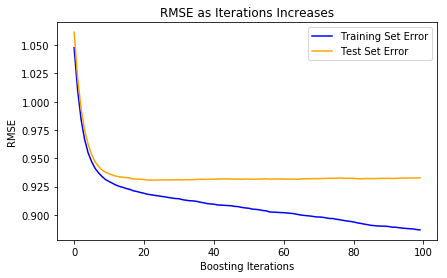

In [1033]:
n_est = 100
test_score = np.zeros(n_est, dtype=np.float64)
y_pred_list = []
#rmse_gb = np.zeros(n_est, dtype=np.float64)

test_score = np.zeros(n_est, dtype=np.float64)
relative_error = np.zeros(n_est, dtype=np.float64)

train_score = np.sqrt(gb.train_score_)
for i, y_pred in enumerate(gb.staged_predict(df_test_X)):
    test_score[i] = np.sqrt(mean_squared_error(df_test_y, y_pred))

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'blue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'orange', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.title("RMSE as Iterations Increases")
plt.savefig("GB_iterations")

print("RMSE: ", np.min(test_score))





In [1034]:
pred_gb = gb.predict(df_test_X)
np.sqrt(mean_squared_error(df_test_y, pred_gb))

0.93271368391507381

In [1035]:
np.argmin(test_score)

23

In [669]:
real_test_score = []
for i, y_pred in enumerate(gb.staged_predict(df_test_X)):
    real_test_score.append(np.sqrt(mean_squared_error(df_test_y, y_pred)))

In [672]:
from sklearn.tree import DecisionTreeRegressor

In [674]:
model_dt = DecisionTreeRegressor(max_depth=5,min_samples_leaf=1,min_samples_split=3 )
model_dt.fit(df_full[['mf','user','item']],df_full['true'])


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [675]:
dt_pred = model_dt.predict(df_full_test[['mf','user','item']])

In [676]:
np.sqrt(mean_squared_error(df_full_test['true'], dt_pred))

1.3516725309812263

Random Forest

In [681]:
from sklearn.ensemble import RandomForestRegressor

In [703]:
n_est = 50

tuned_parameters = {
    "n_estimators": [ 50,100,200 ],
    "max_depth" : [3,4,5,6,7 ],
    "min_samples_leaf": [1,2,3],
    "min_samples_split" : [ 2,3,4 ]
}

rf = RandomForestRegressor(criterion='mse')
rfcv = sklearn.model_selection.GridSearchCV(rf, cv=5, param_grid=tuned_parameters,
        scoring='neg_mean_absolute_error')
rfcv.fit(df_train_X, df_train_y) 


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [705]:
best_rf = rfcv.best_estimator_
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [706]:
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model_rf.fit(df_train_X,df_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [707]:
pred_rf = model_rf.predict(df_test_X)

In [708]:
np.sqrt(mean_squared_error(df_full_test['true'], pred_rf))

1.3517061917827706